In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


df = pd.read_csv("./IRIS.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [2]:
label = "species"

y = df[label].values
X = df.iloc[:,:-1].values

# 1a) PCA

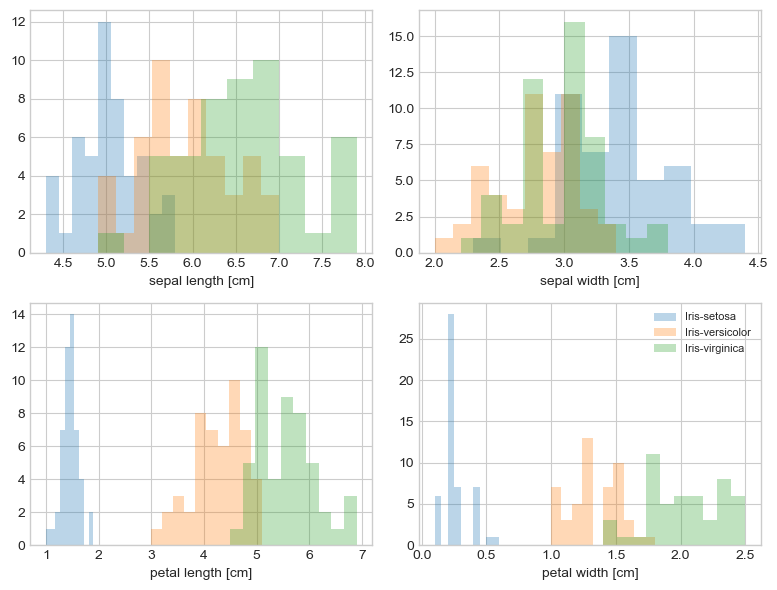

In [3]:
label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.savefig('PREDI.png', format='png', dpi=1200)
    plt.show()

In [4]:
# step 1: standardize the data
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X) 

In [5]:
# step 2: eigendecomposition
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)
np.linalg.norm(eig_vecs[0]) # eigenvectors have unit norm

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


0.9999999999999998

In [6]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.930353775589315
0.9274036215173409
0.14834222648163975
0.02074601399559619


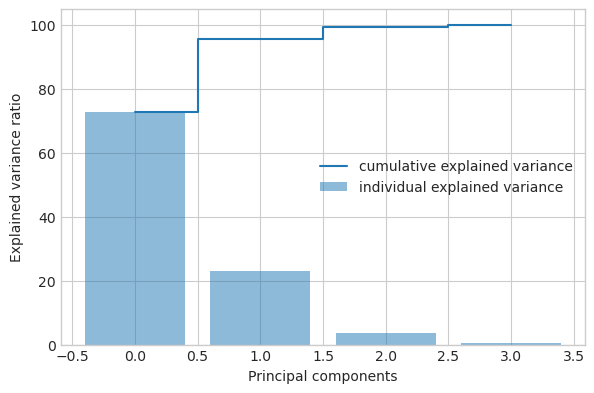

In [7]:
# step 3: determine top k eigenvectors
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig('PREDI2.png', format='png', dpi=1200)
plt.show()

In [8]:
# step 4: make the projection matrix W
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1),
                      eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


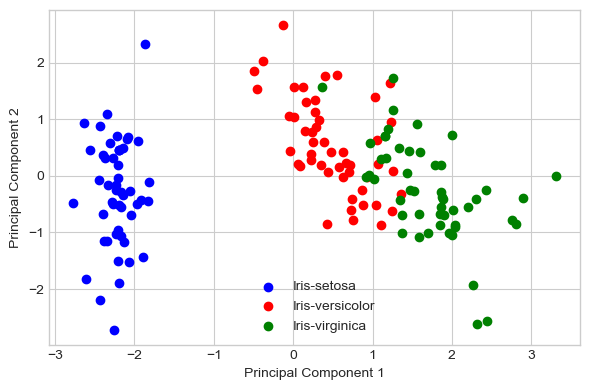

In [9]:
# step 5: project data X onto new feature space
Y = X_std.dot(matrix_w)

with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

# 1b) LDA

In [10]:
# first encode the label so it's convenient to work with
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

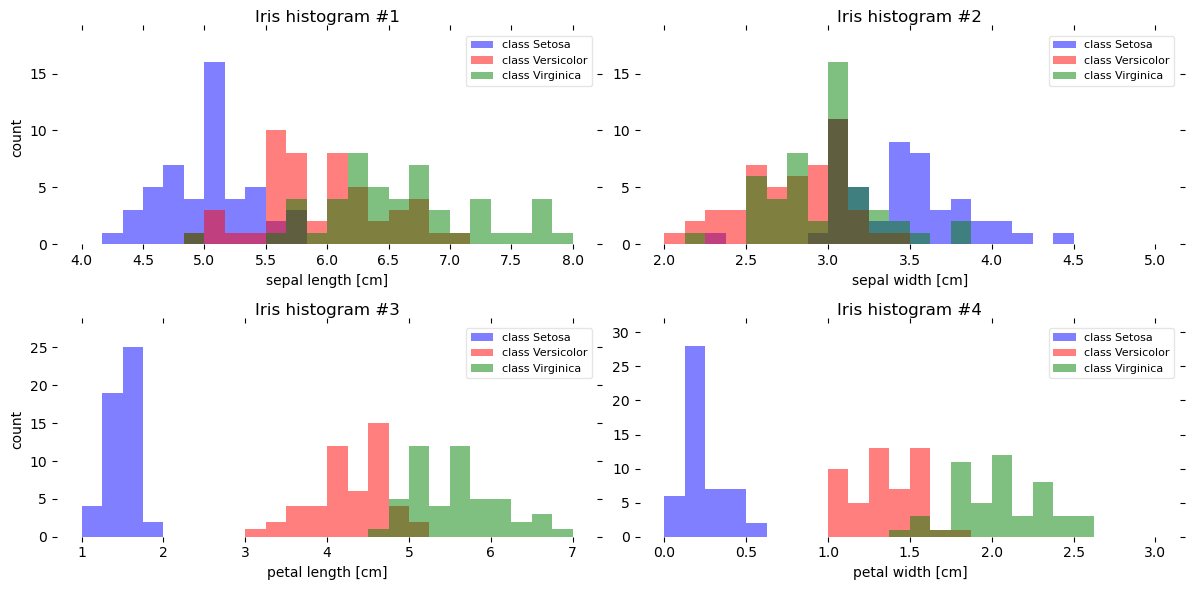

In [11]:
# EDA like before
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

In [12]:
# step 1: mean vectors
np.set_printoptions(precision=4)

mean_vectors = []
for _cls in np.unique(y):
    mean_vectors.append(np.mean(X[y==_cls], axis=0))
    print('Mean Vector class %s: %s\n' %(label_dict[_cls], mean_vectors[_cls-1]))
    
# for use later
global_mean_vector = np.mean(X, axis=0)

Mean Vector class Setosa: [5.006 3.418 1.464 0.244]

Mean Vector class Versicolor: [5.936 2.77  4.26  1.326]

Mean Vector class Virginica: [6.588 2.974 5.552 2.026]



In [13]:
# step 2: scatter matrices
S_W = np.zeros((4,4))
for cl, mv in zip(np.unique(y), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


In [14]:
# between scatter matrix
S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    global_mean_vector = global_mean_vector.reshape(4,1) # make column vector
    S_B += n * (mean_vec - global_mean_vector).dot((mean_vec - global_mean_vector).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


In [15]:
# step 3: eigendecomposition of scatter matrices
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.4287]
 [-0.1529]
 [-0.2261]
 [ 0.8612]]
Eigenvalue 3: -2.43e-15

Eigenvector 4: 
[[ 0.2491]
 [-0.4063]
 [-0.4656]
 [ 0.7458]]
Eigenvalue 4: 5.03e-15


In [16]:
# step 4: choose k << d eigenvectors for new subspace
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])
    
print('\nVariance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Eigenvalues in decreasing order:

32.27195779972979
0.2775668638400533
5.031679977536618e-15
2.427891303550319e-15

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [17]:
# Step 4: cont'd
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


In [18]:
# step 5: transform samples onto the new subspace
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

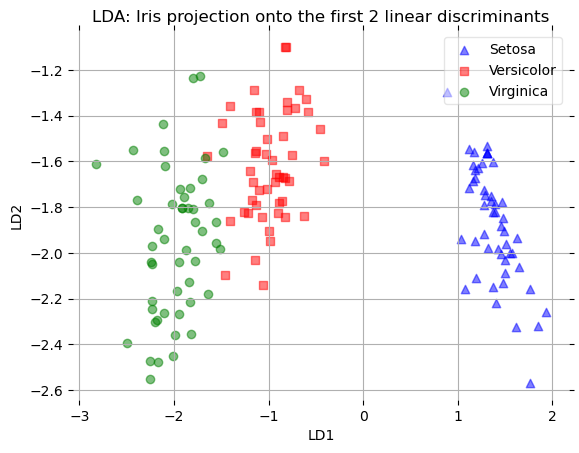

In [19]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

# 2) Explain the difference between two approaches. 

`PCA and LDA are both powerful techniques for dimensionality reduction, but they have different objectives and assumptions.`
- One of the main differences is in their objectives. PCA aims to find the directions of maximum variance in the data, while LDA aims to find the projection that best separates the classes in the data.
- Another difference is in their assumptions. PCA is an unsupervised method that does not take into account the class labels in the data. LDA, on the other hand, is a supervised method that assumes that the data is normally distributed and that the covariance matrices for each class are equal.
- PCA is often used for exploratory data analysis and preprocessing of data for machine learning algorithms, while LDA is often used for classification and feature selection.`

# 3) Colab examples

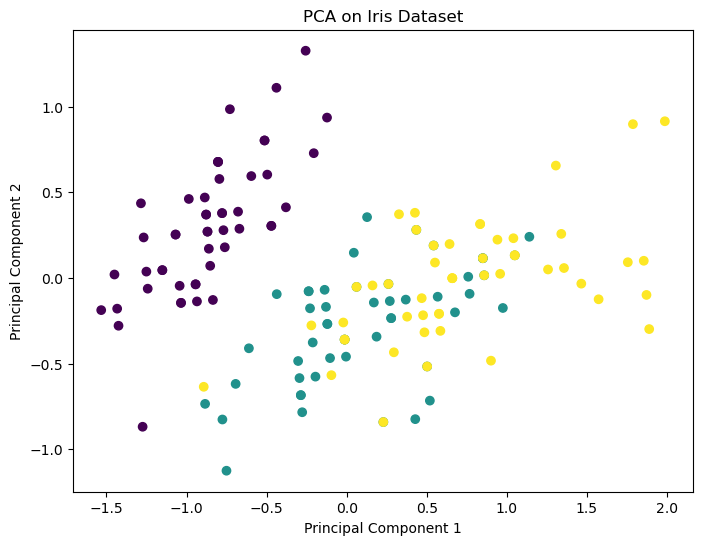

In [20]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # For this example, we'll use only the first 2 features
y = iris.target

# Center the data
X_meaned = X - np.mean(X, axis=0)

# Calculate the covariance matrix and eigendecomposition
cov_mat = np.cov(X_meaned, rowvar=False)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Sort components by explained variance (eigenvalues)
idx = np.argsort(eig_vals)[::-1]
eig_vecs = eig_vecs[:, idx]
eig_vals = eig_vals[idx]

# Select top 2 components (capturing most of the variance)
W = eig_vecs[:, :2]

# Project the data onto the new space
X_reduced = np.dot(X_meaned, W)

# Plot the results
plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Iris Dataset')
plt.show()

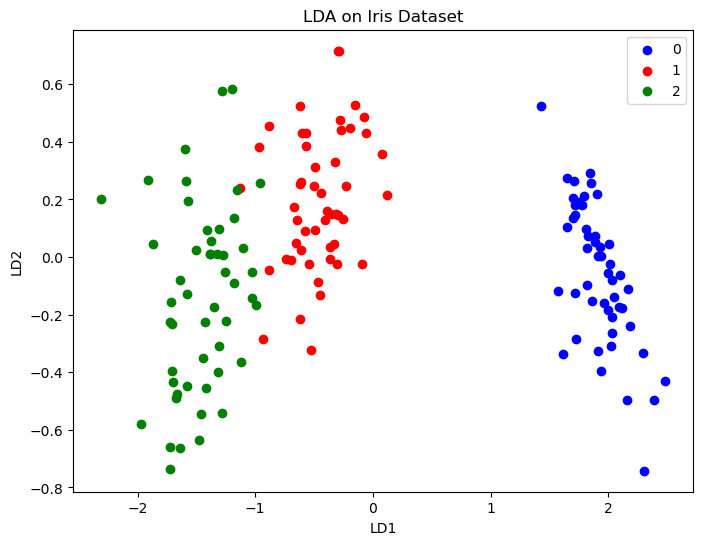

In [21]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Center the data
X_meaned = X - np.mean(X, axis=0)

# Calculate the mean vectors for each class
mean_vectors = []
for cl in range(3):
    mean_vectors.append(np.mean(X_meaned[y == cl], axis=0))

# Calculate the within-class scatter matrix
within_class_scatter = np.zeros((4, 4))
for cl, mv in zip(range(3), mean_vectors):
    class_scatter = np.zeros((4, 4))
    for row in X_meaned[y == cl]:
        row, mv = row.reshape(4, 1), mv.reshape(4, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    within_class_scatter += class_scatter

# Calculate the between-class scatter matrix
overall_mean = np.mean(X_meaned, axis=0).reshape(4, 1)
between_class_scatter = np.zeros((4, 4))
for i, mean_vec in enumerate(mean_vectors):
    n = X_meaned[y == i, :].shape[0]
    mean_vec = mean_vec.reshape(4, 1)
    between_class_scatter += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

# Calculate eigenvectors and eigenvalues of (inverse(w) * b)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(within_class_scatter).dot(between_class_scatter))

# Sort eigenvectors by eigenvalues in decreasing order
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Select top k eigenvectors (discriminants)
W = np.hstack((eig_pairs[0][1].reshape(4, 1), eig_pairs[1][1].reshape(4, 1)))

# Project the data onto the new space
X_lda = X_meaned.dot(W)

# Plot the results
plt.figure(figsize=(8, 6))
for label, color in zip(range(3), ('blue', 'red', 'green')):
    plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1], label=label, c=color)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA on Iris Dataset')
plt.legend(loc='best')
plt.show()

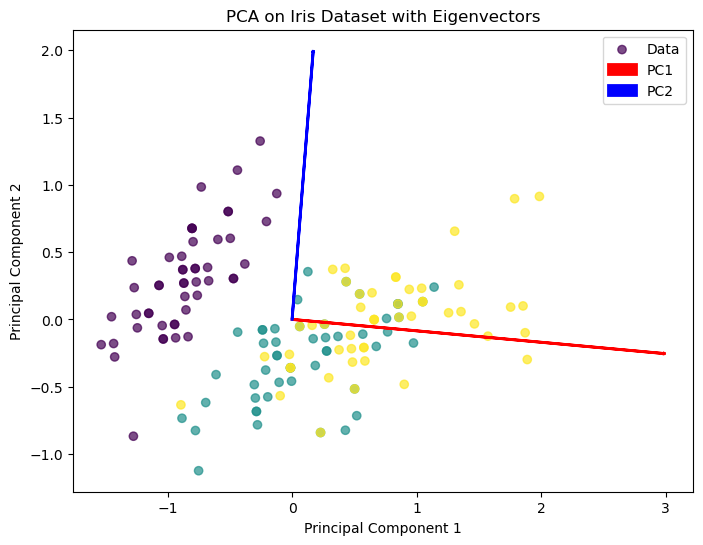

In [22]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # For this example, we'll use only the first 2 features
y = iris.target

# Center the data
X_meaned = X - np.mean(X, axis=0)

# Calculate the covariance matrix and eigendecomposition
cov_mat = np.cov(X_meaned, rowvar=False)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Sort components by explained variance (eigenvalues)
idx = np.argsort(eig_vals)[::-1]
eig_vecs = eig_vecs[:, idx]
eig_vals = eig_vals[idx]

# Select top 2 components (capturing most of the variance)
W = eig_vecs[:, :2]

# Project the data onto the new space
X_reduced = np.dot(X_meaned, W)

# Define scaling factors for visualizing eigenvectors (adjust as needed)
scale1 = 3  # Adjust for better visualization of eigenvector 1
scale2 = 2  # Adjust for better visualization of eigenvector 2

# Plot the results
plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.7, label='Data')

# Plot the eigenvectors with arrows
plt.arrow(0, 0, scale1*eig_vecs[:, 0][0], scale1*eig_vecs[:, 0][1], color='red', linewidth=2, label='PC1')
plt.arrow(0, 0, scale2*eig_vecs[:, 1][0], scale2*eig_vecs[:, 1][1], color='blue', linewidth=2, label='PC2')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Iris Dataset with Eigenvectors')
plt.legend()
plt.show()


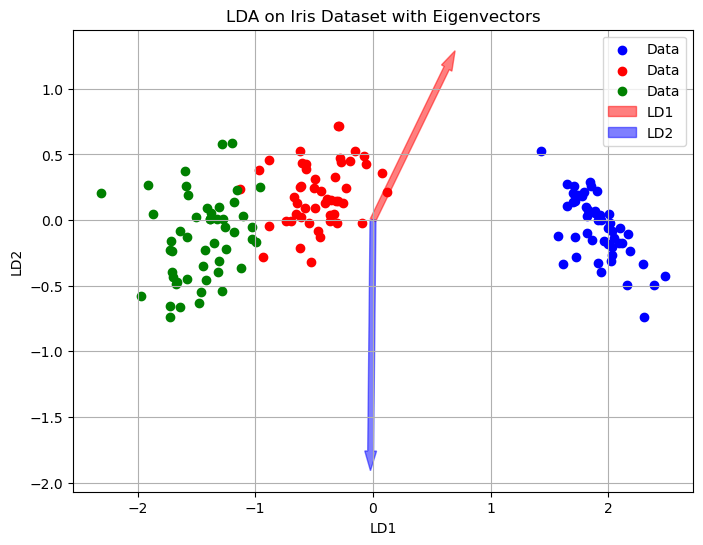

In [23]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Center the data
X_meaned = X - np.mean(X, axis=0)

# Calculate the mean vectors for each class
mean_vectors = []
for cl in range(3):
    mean_vectors.append(np.mean(X_meaned[y == cl], axis=0))

# Calculate the within-class scatter matrix
within_class_scatter = np.zeros((4, 4))
for cl, mv in zip(range(3), mean_vectors):
    class_scatter = np.zeros((4, 4))  # scatter matrix for each class
    for row in X_meaned[y == cl]:
        row, mv = row.reshape(4, 1), mv.reshape(4, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    within_class_scatter += class_scatter  # sum class scatter matrices

# Calculate the between-class scatter matrix
overall_mean = np.mean(X_meaned, axis=0).reshape(4, 1)
between_class_scatter = np.zeros((4, 4))
for i, mean_vec in enumerate(mean_vectors):
    n = X_meaned[y == i, :].shape[0]
    mean_vec = mean_vec.reshape(4, 1)
    between_class_scatter += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

# Calculate eigenvectors and eigenvalues of (inverse(within_class_scatter) * between_class_scatter)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(within_class_scatter).dot(between_class_scatter))

# Sort eigenvectors by eigenvalues in decreasing order
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Select top 2 eigenvectors (discriminants)
W = np.hstack((eig_pairs[0][1].reshape(4, 1), eig_pairs[1][1].reshape(4, 1)))

# Project the data onto the new space
X_lda = X_meaned.dot(W)

# Plot the results
plt.figure(figsize=(8, 6))
for label, color in zip(range(3), ('blue', 'red', 'green')):
    plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1], label='Data', c=color)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA on Iris Dataset with Eigenvectors')

# Plot the discriminants with arrows
colors = ['red', 'blue']  # Define colors for each discriminant
for i in range(W.shape[1]):
    plt.arrow(0, 0, 3*W[0, i], 3*W[1, i], color=colors[i], alpha=0.5, width=0.05, head_width=0.1, label=f'LD{i+1}')
plt.legend(loc='best')
plt.grid()
plt.show()
